In [1]:
import os

from glob import glob
import cv2
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import sys
sys.path.append("/kaggle/src/")

from model.model_module import ModelModule
from conf import ExpConfig
from score.rle_convert import rle_encode, rle_decode
from score.compute_score import compute_surface_dice_score, add_size_columns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
config = ExpConfig()
model = ModelModule(config)
# modelの読み込み
# model_path = "/kaggle/working/exp001_making3/last.pth"
model_path = "/kaggle/working/exp001_validscore/last.pth"
model.load_state_dict(torch.load(model_path))
model.to("cuda")

ModelModule(
  (model): SimpleSegModel(
    (encoder): SimpleTimmEncoder(
      (encoder): EfficientNetFeatures(
        (conv_stem): Conv2dSame(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (blocks): Sequential(
          (0): Sequential(
            (0): DepthwiseSeparableConv(
              (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (bn1): BatchNormAct2d(
                32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): SiLU(inplace=True)
              )
              (se): SqueezeExcite(
                (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
                (act1): SiLU(inplace=True)
                (conv_expand): Conv

In [3]:
data_name = "kidney_1_dense"
slice_id = "0500"
data_id = data_name + "_" + slice_id

image = cv2.imread(f"/kaggle/input/blood-vessel-segmentation/train/{data_name}/images/{slice_id}.tif", cv2.IMREAD_GRAYSCALE)
pred, pred_counts = model.overlap_predict(image)

In [4]:
rle = rle_encode((pred > 0.5).astype(np.uint8))
print(rle)

119938 2 120850 2 121763 1 142766 1 143678 1 147473 1 148384 3 149296 3 150208 1 160213 1 161124 3 162036 3 162947 3 163859 3 170081 4 170992 5 171904 5 172817 3 172836 2 173747 4 174658 6 175569 7 176482 5 177394 5 178307 2 195625 3 196535 5 197392 1 197444 8 198303 3 198356 8 199215 3 199254 2 199268 8 200126 4 200166 2 200179 9 201038 3 201091 8 201950 3 202004 6 202916 6 203193 2 203828 5 204105 3 204740 5 205018 2 205652 4 206565 2 228416 4 229325 8 230236 9 230447 1 231148 10 231358 3 231402 2 232059 11 232270 3 232314 3 232970 12 233182 3 233226 3 233882 9 234793 10 235013 1 235704 10 235924 4 236601 2 236615 11 236836 4 237513 2 237527 10 237749 1 238425 3 238439 10 239337 3 239348 12 240250 2 240259 13 240274 2 241162 3 241170 13 241186 3 242074 3 242082 13 242098 3 242987 2 242994 13 243010 4 243907 12 243921 5 244820 11 244833 5 245733 10 245745 5 246646 8 246657 5 247558 8 247569 5 248470 8 248481 5 249382 8 249393 5 250294 8 250305 4 251205 9 251217 4 252117 9 252129 3 253

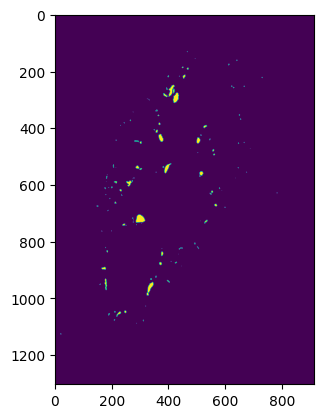

In [5]:
decoded_pred = rle_decode(rle, (pred.shape[0], pred.shape[1]))
plt.imshow(decoded_pred)

In [6]:
# data_name = "kidney_1_dense"
# data_name = "kidney_2"
# data_id_list = []
# rle_list = []
# data_num = len(glob(f"/kaggle/input/blood-vessel-segmentation/train/{data_name}/images/*.tif"))

# for slice_id in tqdm(range(500, 600)):
#     data_id = f"{data_name}_{slice_id:04d}"
#     image = cv2.imread(f"/kaggle/input/blood-vessel-segmentation/train/{data_name}/images/{slice_id:04d}.tif", cv2.IMREAD_GRAYSCALE)
#     pred, pred_counts = model.overlap_predict(image)
#     rle = rle_encode((pred > 0.5).astype(np.uint8))
#     rle_list.append(rle)
#     data_id_list.append(data_id)

# submit = pd.DataFrame({
#     "id": data_id_list,
#     "rle": rle_list
# })

In [7]:
data_dir = config.input_data_dir
train_data_dir = os.path.join(data_dir, "train")
# print(train_data_dir)
# data_name_list = os.listdir(train_data_dir)
data_name_list = ["kidney_2"]
# print(data_name_list)

config.overlap_rate = 0.5
config.threshold = 0.8

submit = model.inference(train_data_dir, data_name_list)

predicting... => kidney_2, slice num: 2217
2200/2217, 3.78 [min]

In [8]:
# submit_sample = pd.read_csv("/kaggle/input/submission_sample.csv")
# submit_sample

In [9]:
data_id_list = submit["id"].values.tolist()

label = pd.read_csv("/kaggle/input/blood-vessel-segmentation/train_rles.csv")
label = label[label["id"].isin(data_id_list)].reset_index(drop=True)
add_size_columns(label)
# label

In [10]:
%%time
# Compute surface Dice score
score = compute_surface_dice_score(submit, label)
score

CPU times: user 5.32 s, sys: 358 µs, total: 5.32 s
Wall time: 5.32 s


0.3847951889038086


overlap=0.2, threshold=0.5 0.402873158454895


overlap=0.5, threshold=0.5 0.3703303039073944

overlap=0.5, threshold=0.1 0.3497748374938965